# Hyperparameters training for Gaussian Process kernels

This code compares the kernel's hyperparameters  trained using 3 codes:
* SKlearn
* GPy
* TFGP - **tfgp_trainer** was written for SLAC National Lab, and uses Tensorflow.   

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")
print(tf.__version__)

2.4.1


# Load data

For this example we load exprimental data from SPEAR3 storage ring at SLAC National Lab.
https://www-ssrl.slac.stanford.edu/spear3/

* X: Input include 13 controls (quadropole current in [mA]).
* Y: Objective includes the beam loss rate [mA/min].


In [2]:
df = pd.read_excel('Data/spear_data.xlsx')
X=df.iloc[:,0:13] 
Y=df['objective']
print('Y.shape',Y.shape,'\nX.shape',X.shape)

Y.shape (120,) 
X.shape (120, 13)


# Training using TFGP trainer

In [3]:
from tfgp_trainer import tfgp_trainer
tf.compat.v1.disable_eager_execution()

In [4]:
Niter = 1200

t0 = time.time()
tfgp = tfgp_trainer(X, Y,verbose=0)

tfgp.train(lr=0.005, 
           niter=Niter,
           optimizer=[tf.compat.v1.train.AdamOptimizer, tf.optimizers.SGD, tf.optimizers.RMSprop][0],
           gradient_clipping=0,
           kernel=['rbf','matern32','matern52'][0],
           correlations = False,
           offset = False,
           monitor_period=None,
           monitor_gradient=None) 

tfgp_t = time.time()-t0
print ('took ',tfgp_t ,' seconds')

100% (1200 of 1200) |####################| Elapsed Time: 0:00:04 Time:  0:00:04


took  5.0740861892700195  seconds


We can then plot results to see behaviour during the optimization and convergance.

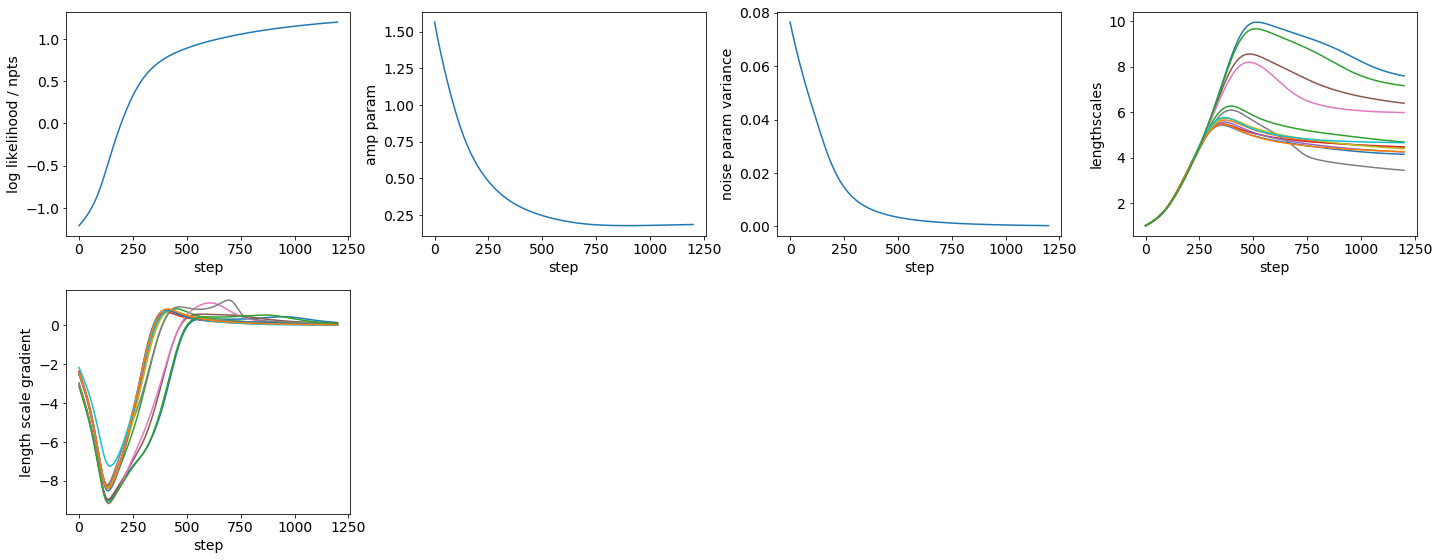

logLiklihod 143.99535004420056 
 amp 0.18642727713041246 
 noise 0.0003118759268952384 
 ls [7.58572558 4.44796738 4.67993025 4.46760632 4.24392061 6.38783723
 5.97562472 3.43810226 4.38975833 4.65116123 4.14185799 4.25689084
 7.15850042]


In [5]:
from utils import GP_plot_results
tfgp_results = GP_plot_results(tfgp,Y)

#  Training using SKlearn

In [6]:
from sk_trainer import sk_trainer
sk=sk_trainer()
sk.sk_train(X, Y, kernels=['rbf'], offset=False, verboseQ=True, saveQ=False)

********* 
 rbf
took  2.1444473266601562  seconds
Inital kernel: 3.16**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.01)
Learned kernel: 0.439**2 * RBF(length_scale=[7.04, 4.34, 4.43, 4.34, 4.06, 5.89, 5.94, 3.2, 4.24, 4.57, 4.03, 4.11, 6.85]) + WhiteKernel(noise_level=0.000139)
Log-marginal-likelihood: 151.525


#  Training using to GPy

In [7]:
from gpy_trainer import gpy_trainer
gpy=gpy_trainer()
gpy.gpy_train(X, Y[:,None], kernels= ['rbf'], max_iters=1000, offset=False, verboseQ=True, saveQ=False)

********* 
 rbf
Optimization restart 1/5, f = -151.5249124577877
Optimization restart 2/5, f = -151.5249123927955
Optimization restart 3/5, f = -151.524912449089
Optimization restart 4/5, f = -151.5249122887625
Optimization restart 5/5, f = -151.5249124568383
took  1.9564263820648193  seconds
Log-marginal-likelihood: 151.525


# Comparison of hyperparameters from all codes

In [8]:
# collect the results into a pandas dataframe to display
pd.DataFrame({"Param": ['time','negative log likelihood', 'amplitude', 'noise', 'offset'],
              "tfgp": [tfgp_t, tfgp_results['ll'], tfgp_results['amp_param'], tfgp_results['noise_param_variance'] , tfgp_results['offset_param']],
              "SK": [sk.sk_t, sk.results['ll'], sk.results['amp_param'], sk.results['noise_param_variance'] , sk.results['offset_param']],
              "GPy": [gpy.gpy_t, gpy.results['ll'], gpy.results['amp_param'], gpy.results['noise_param_variance'] , gpy.results['offset_param']],
             })


,Param,tfgp,SK,GPy
0,time,5.074086,2.144447,1.956426
1,negative log likelihood,-143.995350,151.524912,151.524912
2,amplitude,0.186427,0.192603,0.192604
3,noise,0.000312,0.000139,0.000070
4,offset,NaN,NaN,NaN


In [9]:
print('Lengthscales Comparison')
pd.DataFrame({"": X.keys(),
              "tfgp": tfgp_results['length_scale_param'],
              "SK": sk.results['length_scale_param'] ,
              "GPy": gpy.results['length_scale_param']
             })

Lengthscales Comparison


,,tfgp,SK,GPy
0,01,7.585726,7.036346,7.036307
1,02,4.447967,4.339497,4.339498
2,05,4.679930,4.434527,4.434511
3,07,4.467606,4.336891,4.336880
4,08,4.243921,4.064572,4.064573
5,09,6.387837,5.887950,5.887958
6,10,5.975625,5.944085,5.944072
7,11,3.438102,3.196434,3.196429
8,12,4.389758,4.239965,4.239968
9,14,4.651161,4.574047,4.574050
